In [ ]:
from google.colab import output

In [ ]:
!pip install deap
output.clear()

In [2]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [ ]:
import deap
from deap import base, creator
import random
from deap import tools

ModuleNotFoundError: ignored

# base

In [35]:
class FitnessMin(base.Fitness):
  weights = -1.0,

NameError: ignored

In [ ]:
class Individual():
  def __init__(self, generator):
    self.fitness = FitnessMin()
    self.result = {}
    self._alpha : list = None
    self.generator = generator

  @property
  def alpha(self):
    if self._alpha is None:
      self._alpha = self.generator()
    return self._alpha

  @alpha.setter
  def alpha(self, alpha):
    self._alpha = alpha
    return self

In [ ]:
class GA():
  def init(self):
    pass

  def mate(self):
    pass

  def mutate(self):
    pass

  def select(self):
    pass

  def evaluate(self):
    pass

In [ ]:
class MyGA(GA):
  
  def __init__(self, args):
    self.exp, self.args = Experiment(), args
    self.toolbox = base.Toolbox()
    self.init_func()
    self.init_stats()


  def init_func(self):
    toolbox = self.toolbox
    def aaa():
      return Individual(generator=self._init)
    toolbox.register("population", tools.initRepeat, list, aaa)

    # ops
    toolbox.register("init", self.init)
    toolbox.register("mate", self._mate)
    toolbox.register("mutate", self._mutate)
    toolbox.register("select", tools.selTournament, tournsize=self.args.tournament)
    toolbox.register("evolve", self._evolve)
    toolbox.register("evaluate", self._evaluate)

    self.hall = tools.HallOfFame(1)


  def init_stats(self):
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    self.stats = stats

    self.logbook = tools.Logbook()
    self.logbook.header = "gen", "avg", "std", "min", "max"


  """
  individual operations
  """

  def _init(self):
    return [[0.] * 3, [0.] * 3, [0.] * 3]


  def _mate(self, ind1, ind2):
    for a1, a2 in zip(ind1.alpha, ind2.alpha):
      # tools.cxBlend(a1, a2, alpha = 0.5)
      tools.cxUniform(a1, a2, indpb = 0.5)
    return ind1, ind2


  def _mutate(self, ind):
    alpha = ind.alpha
    for i, a in enumerate(alpha):
      alpha[i], = tools.mutGaussian(a, mu=0, sigma=0.2, indpb=0.2)
    ind.alpha = alpha
    return ind,
  

  def _evaluate(self, ind):
    return torch.sum(torch.tensor(ind.alpha)).item(),


  def _evolve(self, ind):
    pass


  """
  population operations
  """

  def init(self):
    return self.toolbox.population(self.args.population)


  def mate(self, offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < self.args.crossover:
        self.toolbox.mate(child1, child2)


  def mutate(self, offspring):
    for mutant in offspring:
      if random.random() < self.args.mutation:
        self.toolbox.mutate(mutant)


  def select_elite(self, pop):
    elite = tools.selBest(pop, 1)
    elite = list(map(self.toolbox.clone, elite))
    return elite


  def select(self, pop):
    offspring = self.toolbox.select(pop, len(pop))
    offspring = list(map(self.toolbox.clone, offspring))
    return offspring


  def evolve(self, pop):
    self.exp('step_evolution_start')(args)
    for ind in pop:
      self._evolve(ind)
    self.exp('step_evolution_end')(args)


  def evaluate(self, pop):
    fitnesses = map(self.toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
      del ind.fitness.values
      ind.fitness.values = fit
    self.exp('step_evaluate_end')(args)


  def record(self, pop):
    record = self.stats.compile(pop)
    print(record)
    self.logbook.record(gen=self.args.nth_gen, **record)

In [ ]:
class Executor():
  def run(self):
    pass

In [ ]:
# アルゴリズムを表現
class ExecuteGA(Executor):
  
  def __init__(self, ga, args):
    self.args = args
    self.ga = ga

  def run(self):
    ga = self.ga
    exp, args = ga.exp, ga.args = Experiment(), self.args

    args.pop = pop = ga.init()

    exp('evolution_start')(args)
    for g in range(args.generation):
      logging.info('generation %d', g)
      args.nth_gen = g
      exp('generation_start')(args)

      ga.evolve(pop)
      ga.evaluate(pop)
      ga.record(pop)
      elite = ga.select_elite(pop)
      offspring = ga.select(pop)[:-len(elite)]
      ga.mate(offspring)
      ga.mutate(offspring)
      offspring += elite
      pop[:] = offspring

      # self.hall.update(pop)
      exp('generation_end')(args)
    exp('evolution_end')(args)

    return pop

In [ ]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [ ]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      if key not in self.func: return None

      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

# TDGA

In [ ]:
class TDGA(GA):
  
  def __init__(self, args):
    self.exp, self.args = Experiment(), args
    self.toolbox = base.Toolbox()
    self.init_func()
    self.init_stats()
    self.temperature = args.t_init


  def init_func(self):
    toolbox = self.toolbox
    def aaa():
      return Individual(generator=self._init)
    toolbox.register("population", tools.initRepeat, list, aaa)

    # ops
    toolbox.register("init", self.init)
    toolbox.register("mate", self._mate)
    toolbox.register("mutate", self._mutate)
    toolbox.register("evolve", self._evolve)
    toolbox.register("evaluate", self._evaluate)

    self.hall = tools.HallOfFame(1)


  def init_stats(self):
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    self.stats = stats

    self.logbook = tools.Logbook()
    self.logbook.header = "gen", "avg", "std", "min", "max"


  """
  individual operations
  """

  def _init(self):
    return [[0.] * 3, [0.] * 3, [0.] * 3]


  def _mate(self, ind1, ind2):
    for a1, a2 in zip(ind1.alpha, ind2.alpha):
      # tools.cxBlend(a1, a2, alpha = 0.5)
      tools.cxUniform(a1, a2, indpb = 0.5)
    return ind1, ind2


  def _mutate(self, ind):
    alpha = ind.alpha
    for i, a in enumerate(alpha):
      alpha[i], = tools.mutGaussian(a, mu=0, sigma=0.2, indpb=0.2)
    ind.alpha = alpha
    return ind,
  

  def _evaluate(self, ind):
    return torch.sum(torch.tensor(ind.alpha)).item(),


  def _evolve(self, ind):
    pass


  """
  population operations
  """

  def init(self):
    return self.toolbox.population(self.args.population)


  def mate(self, offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < self.args.crossover:
        self.toolbox.mate(child1, child2)


  def mutate(self, offspring):
    for mutant in offspring:
      if random.random() < self.args.mutation:
        self.toolbox.mutate(mutant)


  def select_elite(self, pop):
    elite = tools.selBest(pop, 1)
    elite = list(map(self.toolbox.clone, elite))
    return elite


  def select(self, pop):
    pop = self.compress(pop)

    def closure(pop):
      E_sum, n = sum([ind.fitness.values[0] for ind in pop]), len(pop)
      alpha_sum = sum([torch.tensor(ind.alpha) for ind in pop])
      def compute_F(ind):
        # TODO : ??? wvalues, values
        # ignore H_all
        alpha = torch.tensor(ind.alpha)
        alpha_bar = (alpha_sum + alpha) / (n + 1)
        H_i = torch.pow(torch.mean(torch.pow(alpha - alpha_bar, 2)), 0.5)
        E_bar = (E_sum + ind.fitness.values[0]) / (n + 1)
        F = E_bar - H_i * self.temperature
        return F
      return compute_F

    selected = []
    for i in range(self.args.population):
      f = closure(selected)
      Fs = [f(ind) for ind in pop]
      idx = Fs.index(min(Fs))
      selected += [pop[idx]]

    self.update()

    return list(map(self.toolbox.clone, selected))
    # return selected

  def compress(self, pop):
    if self.args.is_compress:
      # TODO
      pass

    return pop

  def update(self):
    # TODO
    args = self.args
    t = args.nth_gen / args.generation
    self.temperature = pow(args.t_init, 1-t) * pow(args.t_fin, t)


  def evolve(self, pop):
    self.exp('step_evolution_start')(args)
    for ind in pop:
      self._evolve(ind)
    self.exp('step_evolution_end')(args)


  def evaluate(self, pop):
    fitnesses = map(self.toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
      del ind.fitness.values
      ind.fitness.values = fit
    self.exp('step_evaluate_end')(args)


  def record(self, pop):
    record = self.stats.compile(pop)
    print(record)
    self.logbook.record(gen=self.args.nth_gen, **record)

In [ ]:
# アルゴリズムを表現
class ExecuteTDGA(Executor):
  
  def __init__(self, ga, args):
    self.args = args
    self.ga = ga

  def run(self):
    ga = self.ga
    exp, args = ga.exp, ga.args = Experiment(), self.args

    args.pop = pop = ga.init()
    ga.evaluate(pop)

    exp('evolution_start')(args)
    for g in range(args.generation):
      logging.info('generation %d', g)
      args.nth_gen = g
      exp('generation_start')(args)

      elite = ga.select_elite(pop)
      offspring = list(map(ga.toolbox.clone, pop)) # TODO

      ga.mate(offspring)
      gen = pop + offspring
      ga.mutate(gen)
      gen += elite

      ga.evaluate(gen)
      pop[:] = ga.select(gen) # [:] inplace
      ga.record(pop)

      exp('generation_end')(args)
    exp('evolution_end')(args)

    return pop

In [ ]:
state = torch.load('drive/My Drive/ml/exp_tdga-2021-01-07_10-39-12/checkpoint.pth')



In [ ]:
def load_gen(path):
  paths = [os.path.join(path, "ind_%d.pth" % i) for i in range(10)]
  pop = [torch.load(p).result for p in paths]
  return pop

In [ ]:
# state = torch.load('./checkpoint.pth')

In [17]:
results = torch.load('result.pth')

In [21]:
normal = torch.load('result_normal.pth') # w fix
noevo = torch.load('result_noevo.pth') # w, a fix
nofix = torch.load('result_nofix.pth') # 

In [ ]:
dirs = lambda x: 'exp_tdga_full-2021-01-13_16-37-53'
paths = [os.path.join('drive/My Drive/ml', dirs(i), 'gen', '%d' % i) for i in range(150)]
results = [load_gen(path) for path in paths]

In [12]:
# edge = [[i['edge'] for i in g] for g in results]
# acc = [[i['test'][0] for i in g] for g in results]
# loss = [[i['test'][1] for i in g] for g in results]

In [22]:
edge = lambda x: [[i['edge'] for i in g] for g in x]
acc = lambda x: [[i['test'][0] for i in g] for g in x]
loss = lambda x: [[i['test'][1] for i in g] for g in x]

Text(0, 0.5, 'test accuracy [%]')

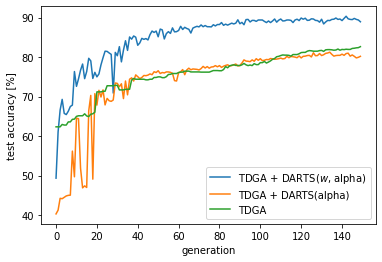

In [33]:
get = lambda x : np.array([x(g) for g in acc(nofix)])
gen = [i for i, g in enumerate(acc(nofix))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS($w$, alpha)')

get = lambda x : np.array([x(g) for g in acc(normal)])
gen = [i for i, g in enumerate(acc(normal))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS(alpha)')

get = lambda x : np.array([x(g) for g in acc(noevo)])
gen = [i for i, g in enumerate(acc(noevo))]
min = get(np.max)
plt.plot(gen, min, label='TDGA')

plt.legend()
plt.xlabel('generation')
plt.ylabel('test accuracy [%]')

Text(0, 0.5, 'test loss')

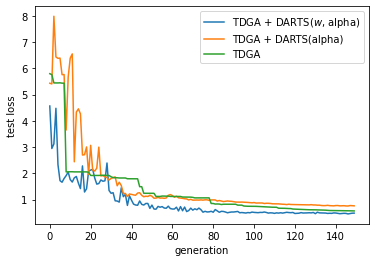

In [37]:
get = lambda x : np.array([x(g) for g in loss(nofix)])
gen = [i for i, g in enumerate(acc(nofix))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS($w$, alpha)')

get = lambda x : np.array([x(g) for g in loss(normal)])
gen = [i for i, g in enumerate(acc(normal))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS(alpha)')

get = lambda x : np.array([x(g) for g in loss(noevo)])
gen = [i for i, g in enumerate(acc(noevo))]
min = get(np.max)
plt.plot(gen, min, label='TDGA')

plt.legend()
plt.xlabel('generation')
plt.ylabel('test loss')

Text(0, 0.5, 'applied shortcut')

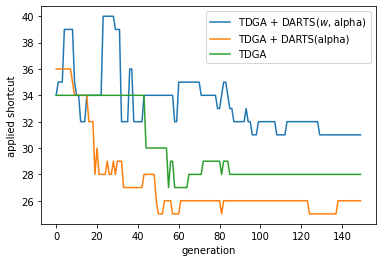

In [34]:
get = lambda x : np.array([x(g) for g in edge(nofix)])
gen = [i for i, g in enumerate(acc(nofix))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS($w$, alpha)')

get = lambda x : np.array([x(g) for g in edge(normal)])
gen = [i for i, g in enumerate(acc(normal))]
min = get(np.max)
plt.plot(gen, min, label='TDGA + DARTS(alpha)')

get = lambda x : np.array([x(g) for g in edge(noevo)])
gen = [i for i, g in enumerate(acc(noevo))]
min = get(np.max)
plt.plot(gen, min, label='TDGA')

plt.legend()
plt.xlabel('generation')
plt.ylabel('applied shortcut')

Text(0, 0.5, 'test accuracy [%]')

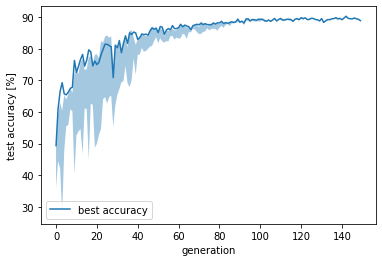

In [18]:
get = lambda x : np.array([x(g) for g in acc])
gen = [i for i, g in enumerate(acc)]
avg = get(np.mean)
std = get(np.std)
min = get(np.max)
plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
plt.plot(gen, min, label='best accuracy')

plt.legend()
plt.xlabel('generation')
plt.ylabel('test accuracy [%]')

In [21]:
base = [93.65]
x = [50, 100, 150]
normal = [93.88, 94.08, 94.13] # 240min exp_tdga_pretrain-2021-01-25_14-09-45
nofix = [94.03, 94.1, 93.85] # 240min exp_tdga_pretrain_nofix-2021-02-05_14-47-19
noevo = [93.9, 94.17, 94.17] # 15 min exp_tdga_pretrain_noevo-2021-02-04_13-09-22

Text(0, 0.5, 'evaluate accuracy [%]')

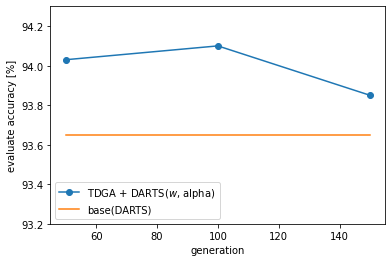

In [23]:

plt.plot(x, nofix, label='TDGA + DARTS($w$, alpha)', marker='o')
plt.plot(x, base * len(x), label='base(DARTS)')

for _x, _y in zip(x, y):
    plt.text(_x, _y - 0.01, _y, ha='center', va='top', color='darkorange')

# for _x, _y in zip(x, y2):
#     plt.text(_x, _y - 0.01, _y, ha='center', va='top', color='green')

plt.legend()

plt.ylim(top=94.3, bottom=93.2)
plt.xlabel('generation')
plt.ylabel('evaluate accuracy [%]')

Text(0, 0.5, 'evaluate accuracy [%]')

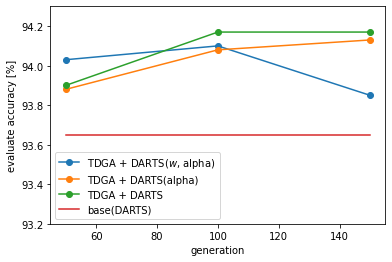

In [24]:

plt.plot(x, nofix, label='TDGA + DARTS($w$, alpha)', marker='o')
plt.plot(x, normal, label='TDGA + DARTS(alpha)', marker='o')
plt.plot(x, noevo, label='TDGA + DARTS', marker='o')
plt.plot(x, base * len(x), label='base(DARTS)')

# for _x, _y in zip(x, y):
#     plt.text(_x, _y - 0.01, _y, ha='center', va='top', color='darkorange')

# for _x, _y in zip(x, y2):
#     plt.text(_x, _y - 0.01, _y, ha='center', va='top', color='green')

plt.legend()

plt.ylim(top=94.3, bottom=93.2)
plt.xlabel('generation')
plt.ylabel('evaluate accuracy [%]')

Text(0, 0.5, 'test loss')

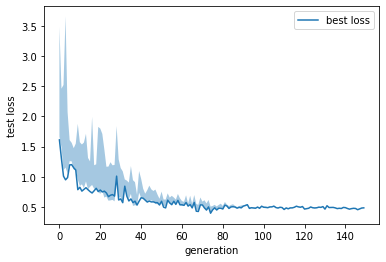

In [19]:
get = lambda x : np.array([x(g) for g in loss])
gen = [i for i, g in enumerate(loss)]
avg = get(np.mean)
std = get(np.std)
min = get(np.min)
plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
plt.plot(gen, min, label='best loss')

plt.legend()
plt.xlabel('generation')
plt.ylabel('test loss')

Text(0, 0.5, 'shortcut edges')

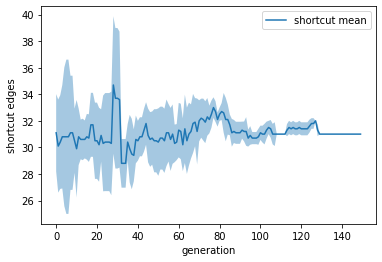

In [20]:
get = lambda x : np.array([x(g) for g in edge])
gen = [i for i, g in enumerate(edge)]
avg = get(np.mean)
std = get(np.std)
min = get(np.min)
plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
plt.plot(gen, avg, label='shortcut mean')

plt.legend()
plt.xlabel('generation')
plt.ylabel('shortcut edges')

No handles with labels found to put in legend.


Text(0, 0.5, 'test loss')

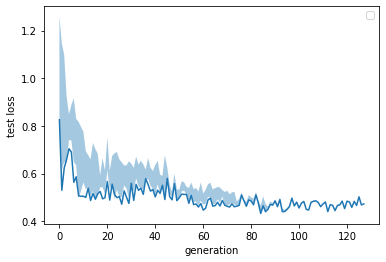

In [ ]:
logbook = state['logbook']
plot_fitness(logbook)
plt.legend()
plt.xlabel('generation')
plt.ylabel('test loss')

In [ ]:
def plot_fitness(logbook):
  get = lambda x : np.array(logbook.select(x))
  gen = get('gen')
  avg = get('avg')
  std = get('std')
  min = get('min')
  # plt.errorbar(gen, avg, yerr=std, capsize=4, linestyle="dashed")
  plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
  plt.plot(gen, min)

In [ ]:
logbook = tdgabook
get = lambda x : np.array(logbook.select(x))
gen = get('gen')
avg = get('avg')
std = get('std')
min = get('min')
plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
plt.plot(gen, min, label='TDGA')

logbook = gabook
get = lambda x : np.array(logbook.select(x))
gen = get('gen')
avg = get('avg')
std = get('std')
min = get('min')
plt.fill_between(gen, avg-std, avg+std, alpha=0.4)
plt.plot(gen, min, linestyle='dashed', label='base')
plt.legend()
plt.xlabel('generation')
plt.ylabel('fitness')

NameError: ignored

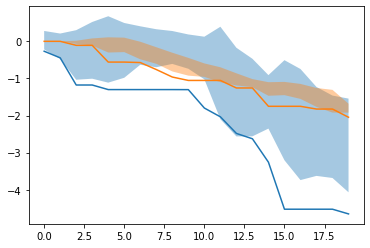

In [ ]:
plot_fitness(tdgabook)
plot_fitness(gabook)

In [ ]:
args = argparse.Namespace(tournament=2, population=10, generation=20, crossover=0.5, mutation=0.2)
ga = MyGA(args)
exec = ExecuteGA(ga, args)
_ = exec.run()
print(ga.logbook)
gabook = ga.logbook

{'avg': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
{'avg': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
{'avg': -0.025718975439667703, 'std': 0.04121663218918959, 'min': -0.1079249158501625, 'max': 0.0}
{'avg': -0.016841447725892068, 'std': 0.09542941451483306, 'min': -0.1079249158501625, 'max': 0.1629573106765747}
{'avg': -0.09683006666600705, 'std': 0.20501403335166718, 'min': -0.559196949005127, 'max': 0.2178102284669876}
{'avg': -0.09561670757830143, 'std': 0.19480691030107905, 'min': -0.559196949005127, 'max': 0.16312597692012787}
{'avg': -0.2472881518304348, 'std': 0.23667192495452968, 'min': -0.5717084407806396, 'max': 0.1304466277360916}
{'avg': -0.3816030155867338, 'std': 0.22313724880278624, 'min': -0.7602194547653198, 'max': -0.0544460229575634}
{'avg': -0.5591339558362961, 'std': 0.25220699307654587, 'min': -0.9621897339820862, 'max': 0.03637859225273132}
{'avg': -0.6850020557641983, 'std': 0.23966542976437494, 'min': -1.053809642791748, 'max': -0.1270025670528412}
{'avg': -0.776

In [ ]:
args = argparse.Namespace(population=10, generation=20, crossover=0.5, mutation=0.2,
                          t_init=10, t_fin=2, is_compress=False)
ga = TDGA(args)
exec = ExecuteTDGA(ga, args)
_ = exec.run()
print(ga.logbook)
tdgabook = ga.logbook

{'avg': 0.030676282942295074, 'std': 0.24894052124174024, 'min': -0.2668963372707367, 'max': 0.33282414078712463}
{'avg': -0.13213477581739425, 'std': 0.3422431196399245, 'min': -0.4449181854724884, 'max': 0.33282414078712463}
{'avg': -0.367224808037281, 'std': 0.6677540735011791, 'min': -1.1770765781402588, 'max': 0.33282414078712463}
{'avg': -0.24292274117469786, 'std': 0.764294684458896, 'min': -1.1770765781402588, 'max': 0.442882239818573}
{'avg': -0.21873950362205505, 'std': 0.8947877592944257, 'min': -1.3003958463668823, 'max': 0.6879187226295471}
{'avg': -0.2436932623386383, 'std': 0.7381443564423376, 'min': -1.3003958463668823, 'max': 0.5369812250137329}
{'avg': -0.11301421225070954, 'std': 0.5182778550250834, 'min': -1.3003958463668823, 'max': 0.40353959798812866}
{'avg': -0.18586994260549544, 'std': 0.512055854799599, 'min': -1.3003958463668823, 'max': 0.4073449969291687}
{'avg': -0.16541411280632018, 'std': 0.4434001455701214, 'min': -1.3003958463668823, 'max': 0.64501190185